# Clustering Analysis for Electric Load Forecasting

This notebook implements various clustering techniques to segment data points based on weather and consumption patterns. We'll identify natural groupings in the data that can provide insights into electricity usage patterns and their relationship with weather conditions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Loading the Dataset

Loading the sample dataset containing weather and consumption data.

In [42]:
print("\n" + "="*80)
print("LOADING 10K SAMPLE DATASET FOR CLUSTERING")
print("="*80)

# Load the 10k sample dataset instead of using the full dataset
sample_path = './dataset/processed/samples/sample_10000_clean_merged_data.csv'

if os.path.exists(sample_path):
    # Replace the current data variable with the sampled data
    data = pd.read_csv(sample_path)
    print(f"Using 10k sample dataset with shape: {data.shape}")
    
    # Convert timestamp to datetime if needed
    if 'timestamp' in data.columns and not pd.api.types.is_datetime64_dtype(data['timestamp']):
        data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Display the first few rows of the sample
    display(data.head())
    
    # Display a summary of the cities in the sample
    if 'city' in data.columns:
        city_counts = data['city'].value_counts()
        print(f"\nNumber of cities in sample: {len(city_counts)}")
        print("Records per city in sample:")
        display(city_counts)
else:
    print(f"Warning: Sample file not found at {sample_path}")
    print("Continuing with the original dataset. Processing may be slow.")

print("="*80)


LOADING 10K SAMPLE DATASET FOR CLUSTERING
Using 10k sample dataset with shape: (10000, 25)


,timestamp,city,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,...,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,date,week,anomaly_z,anomaly_iqr,anomaly_iso
0,2020-03-07 11:00:00,la,8743.00,55.81,0.80,2.97,1015.4,0.0016,0.02,11,...,0.80,0.108791,0.591118,0.001292,0.02,2020-03-07,10,False,False,False
1,2019-05-31 20:00:00,phoenix,4202.00,91.09,0.13,5.35,1008.6,0.0000,0.00,20,...,0.13,0.195971,0.486983,0.000000,0.00,2019-05-31,22,False,False,False
2,2018-07-23 17:00:00,san_antonio,12624.54,94.71,0.35,4.69,1012.2,0.0000,0.00,17,...,0.35,0.171795,0.542113,0.000000,0.00,2018-07-23,30,False,False,False
3,2020-01-30 09:00:00,seattle,1357.00,42.87,0.98,2.47,1024.9,0.0016,0.05,9,...,0.98,0.090476,0.736600,0.001292,0.05,2020-01-30,5,False,False,False
4,2019-03-19 16:00:00,la,10710.00,58.45,0.69,1.99,1015.0,0.0011,0.01,16,...,0.69,0.072894,0.584992,0.000888,0.01,2019-03-19,12,False,False,False



Number of cities in sample: 10
Records per city in sample:


city
houston         1350
san_antonio     1301
dallas          1272
san_diego        925
la               923
san_jose         913
phoenix          888
seattle          864
nyc              817
philadelphia     747
Name: count, dtype: int64

In [ ]:
feature_cols = [
    'demand',        
    'temperature',   
    'humidity',       
    'windSpeed',      
    'hour',         
    'dayofweek',      
    'month'           
]

# Check if all columns exist in the dataset
feature_cols = [col for col in feature_cols if col in data.columns]
print(f"Selected features for clustering: {feature_cols}")

# Extract features for clustering
X = data[feature_cols].copy()

# Scale the features to ensure equal importance in clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")

# Create a scaled DataFrame for reference
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
display(X_scaled_df.head())

Selected features for clustering: ['demand', 'temperature', 'humidity', 'windSpeed', 'hour', 'dayofweek', 'month']
Scaled data shape: (10000, 7)


,demand,temperature,humidity,windSpeed,hour,dayofweek,month
0,0.220045,-0.558321,0.642447,-0.884030,-0.047385,0.992718,-1.013239
1,-0.728530,1.723701,-2.426202,-0.145568,1.242972,0.497770,-0.448839
2,1.030864,1.957854,-1.418586,-0.350352,0.812853,-1.482024,0.115561
3,-1.322825,-1.395321,1.466860,-1.039169,-0.334131,0.002821,-1.577639
4,0.630933,-0.387557,0.138639,-1.188102,0.669480,-0.987076,-1.013239


# 1. Dimensionality Reduction

Before applying clustering algorithms, we'll use dimensionality reduction techniques to visualize the high-dimensional data in 2D space. This will help us get an initial understanding of the potential cluster patterns.

We'll apply two popular techniques:
1. Principal Component Analysis (PCA) - A linear technique
2. t-distributed Stochastic Neighbor Embedding (t-SNE) - A non-linear technique

Explained variance by the first two principal components: 0.24, 0.16
Total explained variance: 0.40


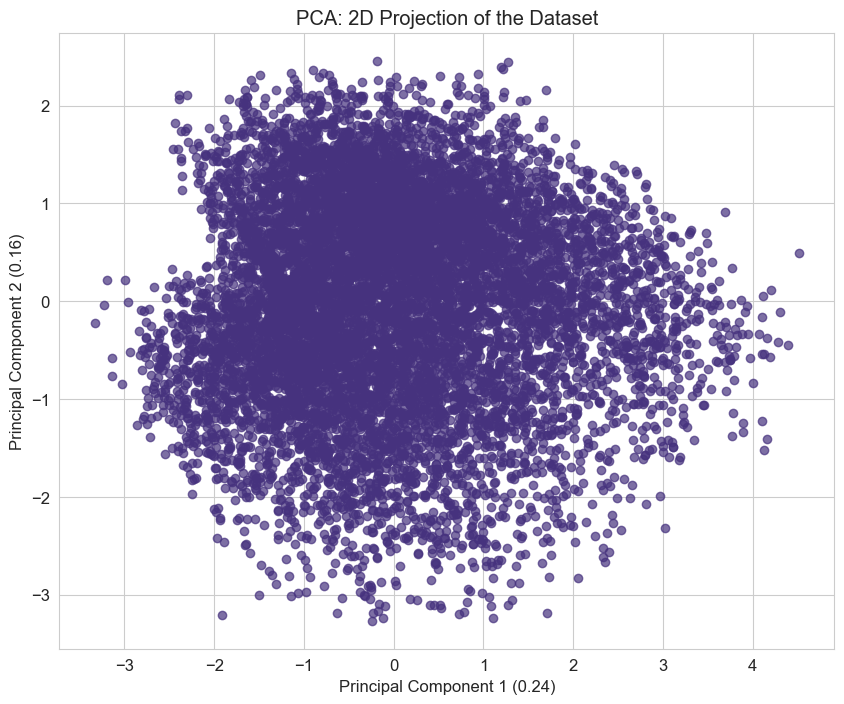

,PC1,PC2
demand,0.627831,-0.027855
temperature,0.773948,0.237089
humidity,-0.521540,-0.038382
windSpeed,0.338751,-0.593540
hour,0.451981,-0.387779
dayofweek,-0.044126,0.163943
month,0.273989,0.720985


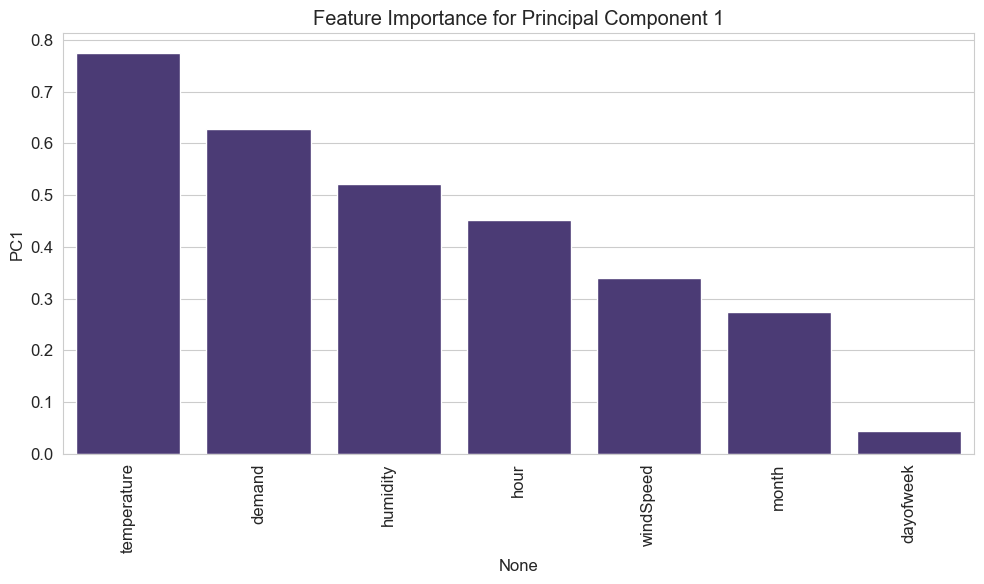

In [44]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a dataframe with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by the first two principal components: {explained_variance[0]:.2f}, {explained_variance[1]:.2f}")
print(f"Total explained variance: {sum(explained_variance):.2f}")

# Visualize the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('PCA: 2D Projection of the Dataset')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f})')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f})')
plt.grid(True)
plt.show()

# View the contribution of features to the principal components
if len(feature_cols) <= 10:  # Only show for manageable number of features
    loading_scores = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_), 
        columns=['PC1', 'PC2'],
        index=feature_cols
    )
    display(loading_scores)
    
    # Plot feature importance for PC1
    plt.figure(figsize=(10, 6))
    sns.barplot(x=loading_scores['PC1'].abs().sort_values(ascending=False).index, 
                y=loading_scores['PC1'].abs().sort_values(ascending=False))
    plt.xticks(rotation=90)
    plt.title('Feature Importance for Principal Component 1')
    plt.tight_layout()
    plt.show()

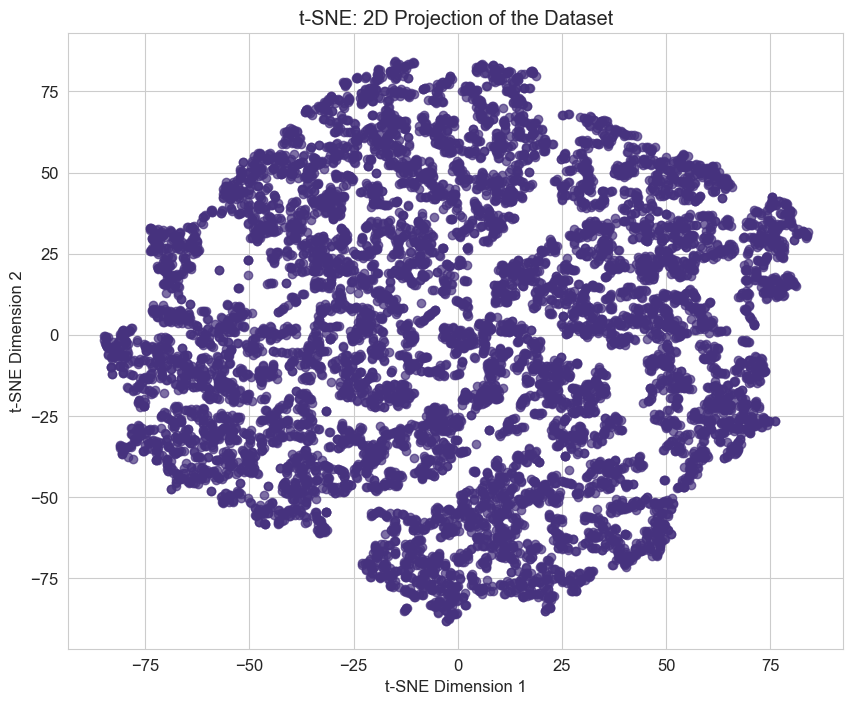

In [45]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Create a dataframe with t-SNE results
tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('t-SNE: 2D Projection of the Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

# 2. K-Means Clustering

K-Means is one of the most popular clustering algorithms. It partitions the data into K distinct clusters by minimizing the within-cluster sum of squares. We'll determine the optimal number of clusters using the Elbow Method and Silhouette Score.

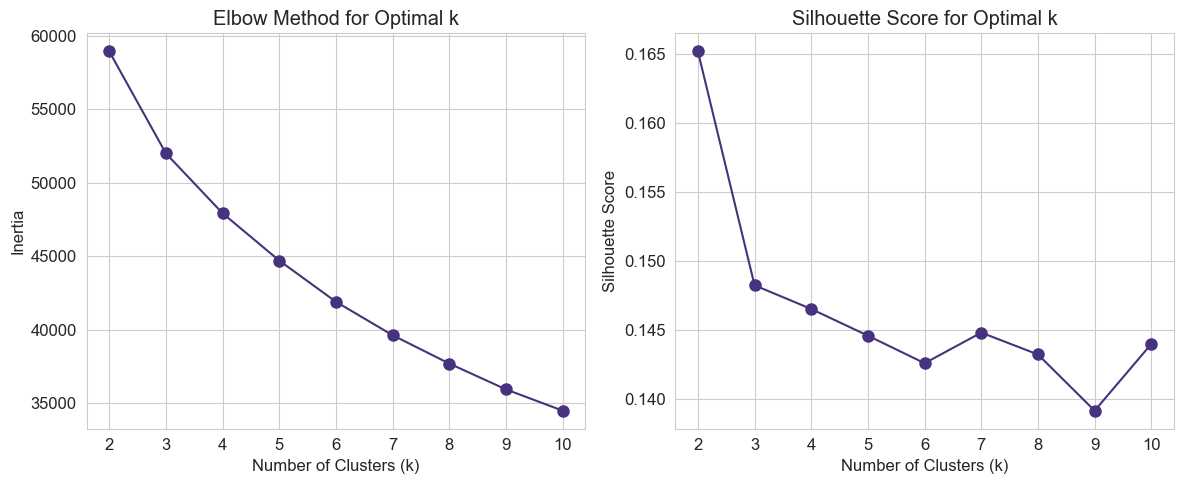

Optimal number of clusters based on silhouette score: 2


In [46]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    # Train the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Collect inertia (sum of squared distances to closest centroid)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    
# Plot the Elbow Method results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'o-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'o-', markersize=8)
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find the optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

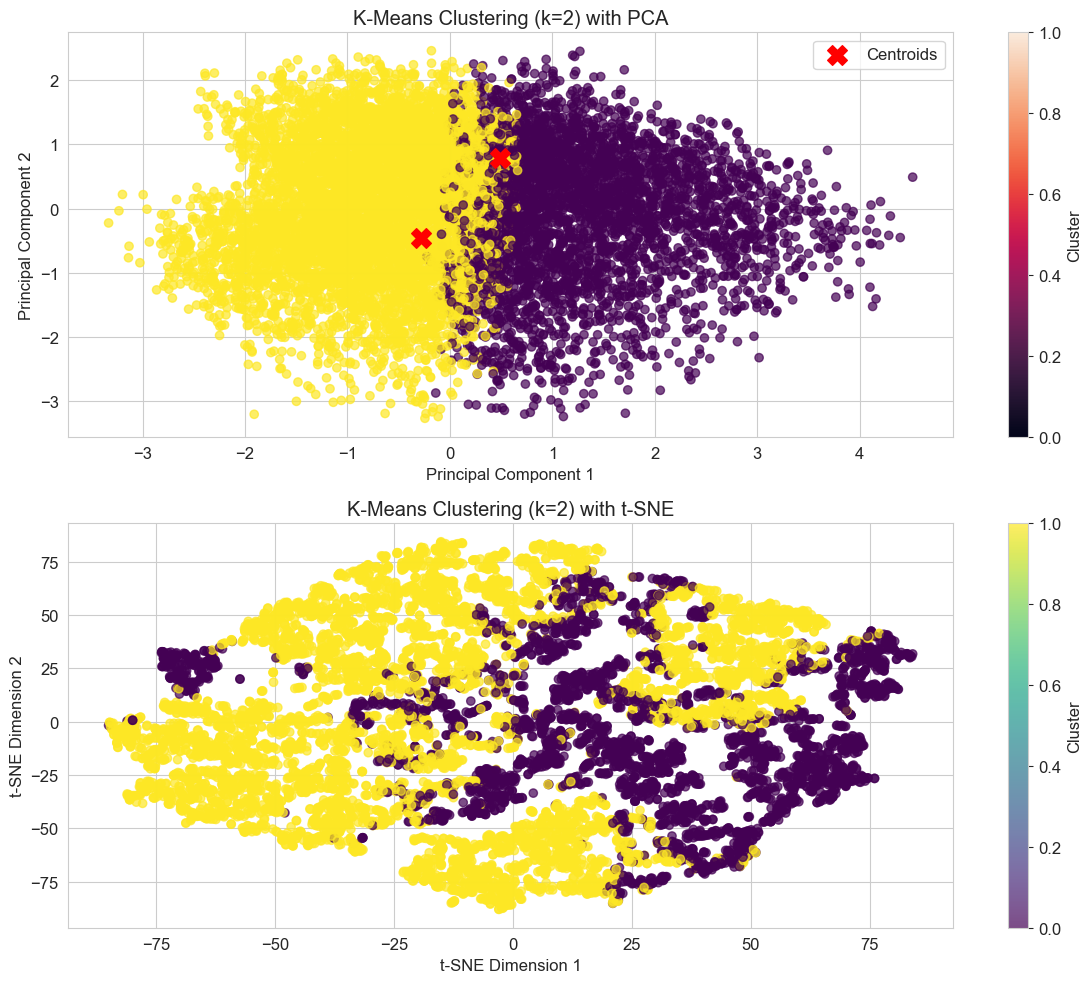

In [47]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
data['KMeans_Cluster'] = kmeans_labels

# Visualize clusters using PCA
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='X', s=200, alpha=1, label='Centroids')
plt.title(f'K-Means Clustering (k={optimal_k}) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(label='Cluster')

# Visualize clusters using t-SNE
plt.subplot(2, 1, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering (k={optimal_k}) with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# Analyze the characteristics of each K-Means cluster

,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,dayofweek,month,demand_scaled,temperature_scaled,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,week,KMeans_Cluster
KMeans_Cluster,,,,,,,,,,,,,,,,,,,
0,10054.409883,76.635892,0.498463,6.936523,1014.843122,0.003102,0.025813,15.381277,2.913755,7.301856,0.110892,0.661439,0.498463,0.254085,0.582590,0.002505,0.025813,29.891648,0.0
1,6322.081013,57.389894,0.752988,5.172999,1016.901436,0.004362,0.071193,8.988005,3.040878,6.179135,0.074569,0.487188,0.752988,0.189487,0.614111,0.003522,0.071193,25.011995,1.0


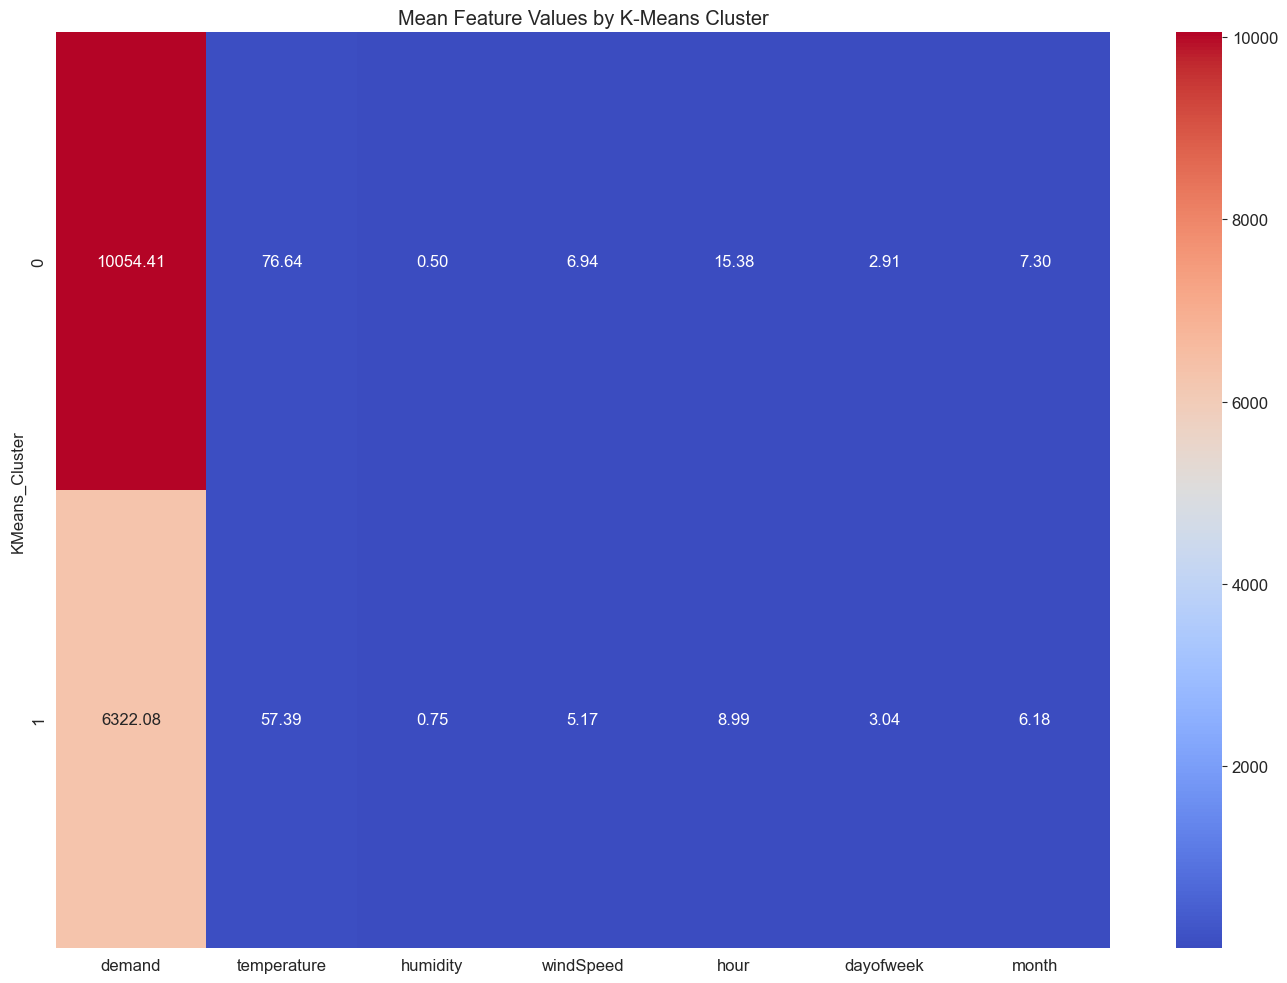

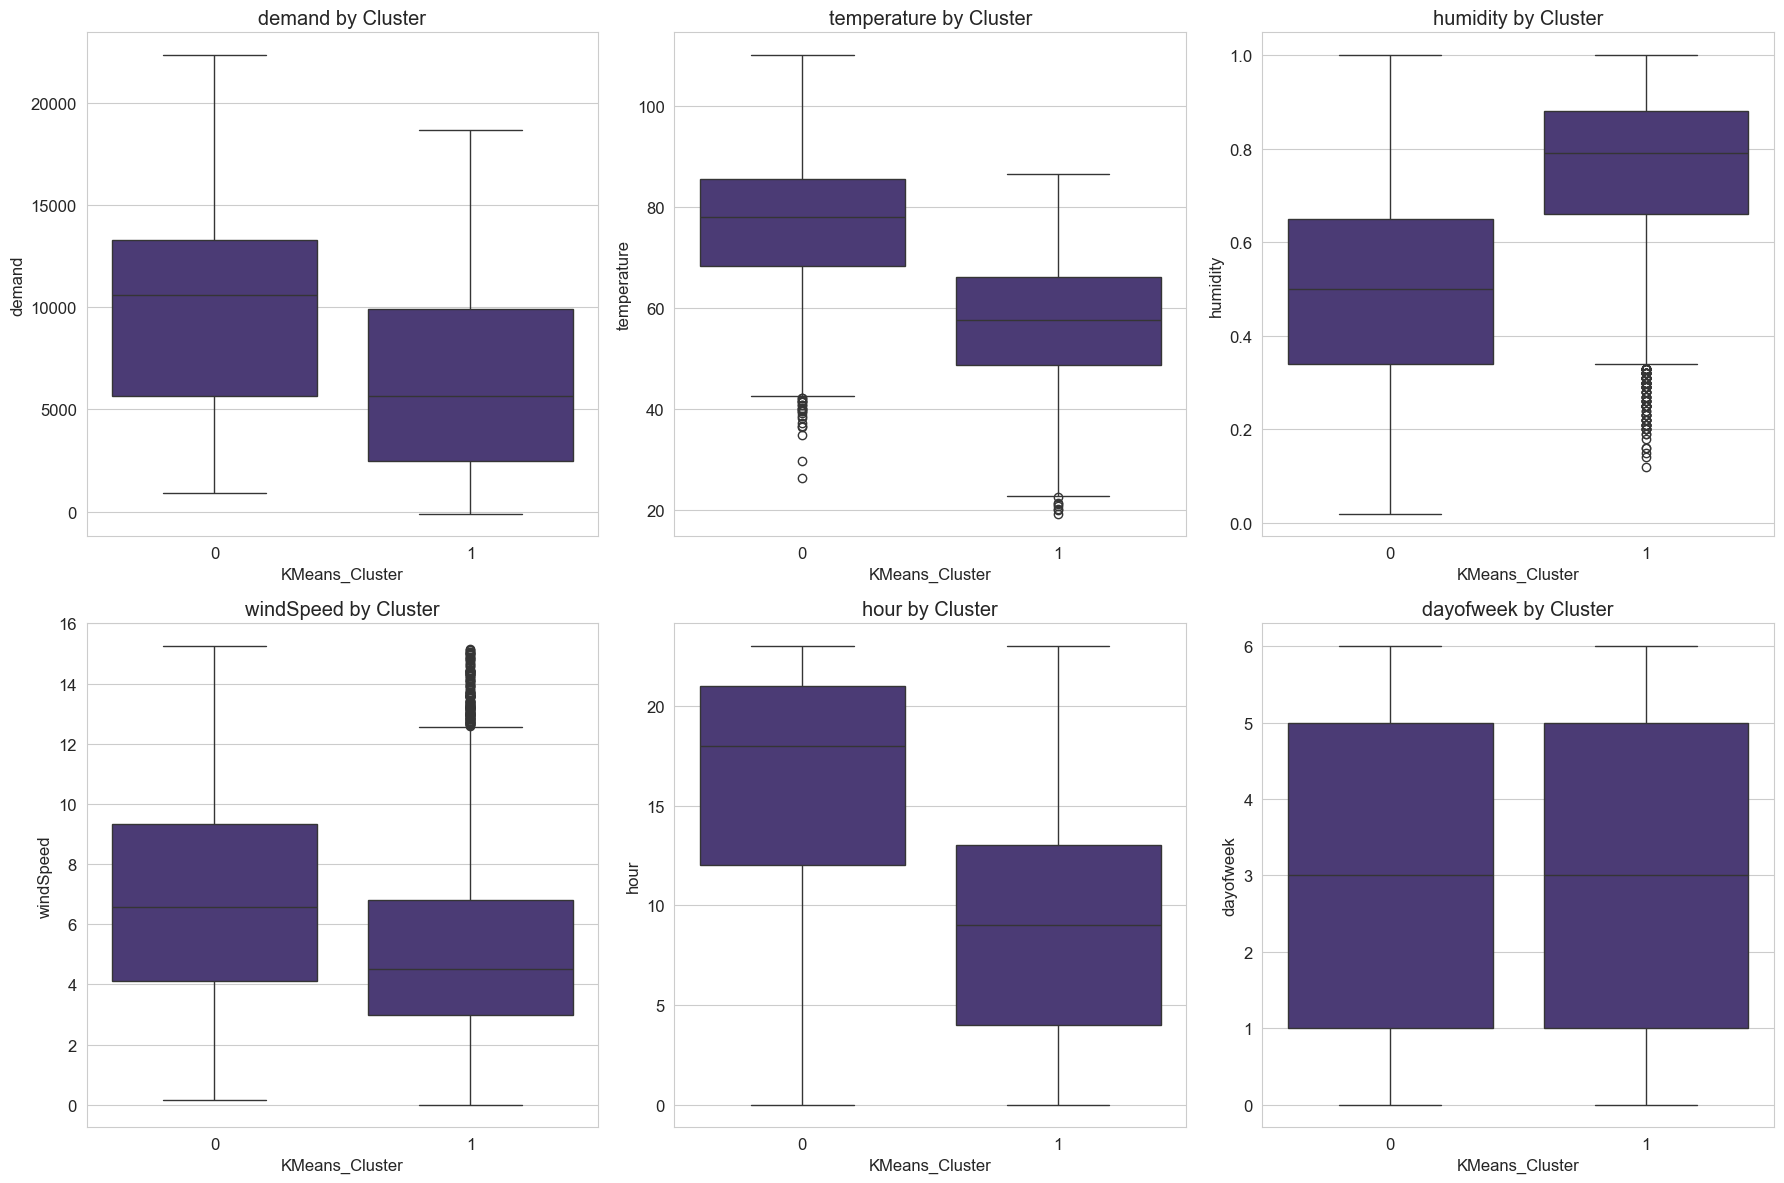

In [ ]:
numeric_columns = data.select_dtypes(include=['number']).columns
kmeans_cluster_analysis = data.groupby('KMeans_Cluster')[numeric_columns].mean()
display(kmeans_cluster_analysis)

# Create a heatmap of cluster characteristics for selected features
plt.figure(figsize=(14, 10))
# Select only the original features for the heatmap to make it more interpretable
cluster_features = kmeans_cluster_analysis[feature_cols]
sns.heatmap(cluster_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mean Feature Values by K-Means Cluster')
plt.tight_layout()
plt.show()

# Boxplots for key features across clusters
if len(feature_cols) <= 6:
    # For a manageable number of features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(feature_cols):
        if i < len(axes):
            sns.boxplot(x='KMeans_Cluster', y=feature, data=data, ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
    
    plt.tight_layout()
    plt.show()
else:
    # For too many features, select a few important ones
    selected_features = feature_cols[:6]
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(selected_features):
        sns.boxplot(x='KMeans_Cluster', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'{feature} by Cluster')
    
    plt.tight_layout()
    plt.show()

# 3. DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that can find arbitrarily shaped clusters and identify outliers as noise. It's particularly useful when clusters have irregular shapes.

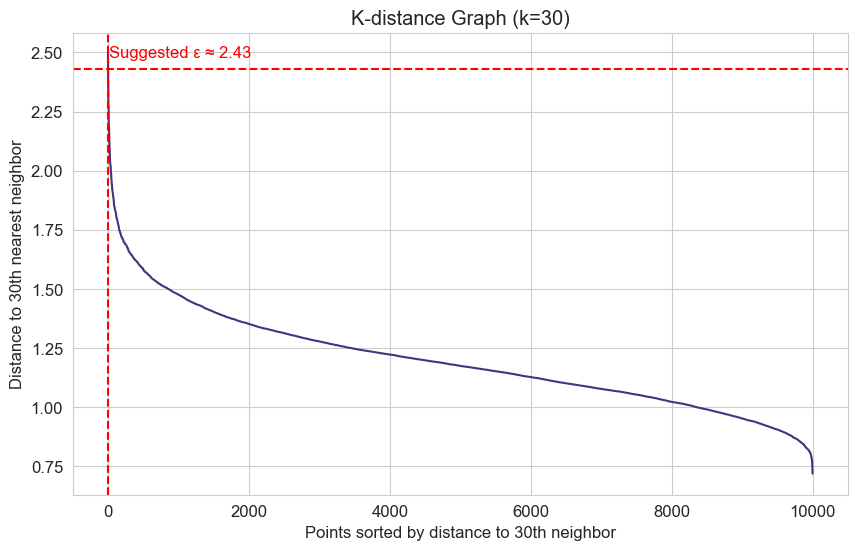

Suggested epsilon: 2.43


In [ ]:
from sklearn.neighbors import NearestNeighbors

# Calculate distances to k-nearest neighbors
k = min(len(X_scaled) - 1, 30)  # k should be less than the number of samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot distances to k-th nearest neighbor
distance_desc = np.sort(distances[:, k-1])[::-1]

plt.figure(figsize=(10, 6))
plt.plot(distance_desc)
plt.title('K-distance Graph (k={})'.format(k))
plt.xlabel('Points sorted by distance to {}th neighbor'.format(k))
plt.ylabel('Distance to {}th nearest neighbor'.format(k))
plt.grid(True)

# Add a line at the "elbow" point where the curve starts to increase rapidly
# This is a suggested value for epsilon
elbow_point = len(distance_desc) - np.argmax(distance_desc[::-1])
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.axhline(y=distance_desc[elbow_point], color='r', linestyle='--')
plt.text(elbow_point + 10, distance_desc[elbow_point] + 0.05, 
         f'Suggested ε ≈ {distance_desc[elbow_point]:.2f}', color='r')

plt.show()

# Choose epsilon based on the elbow in the k-distance graph
epsilon = distance_desc[elbow_point]
print(f"Suggested epsilon: {epsilon:.2f}")

Number of clusters: 1
Number of noise points: 0 (0.00% of the dataset)


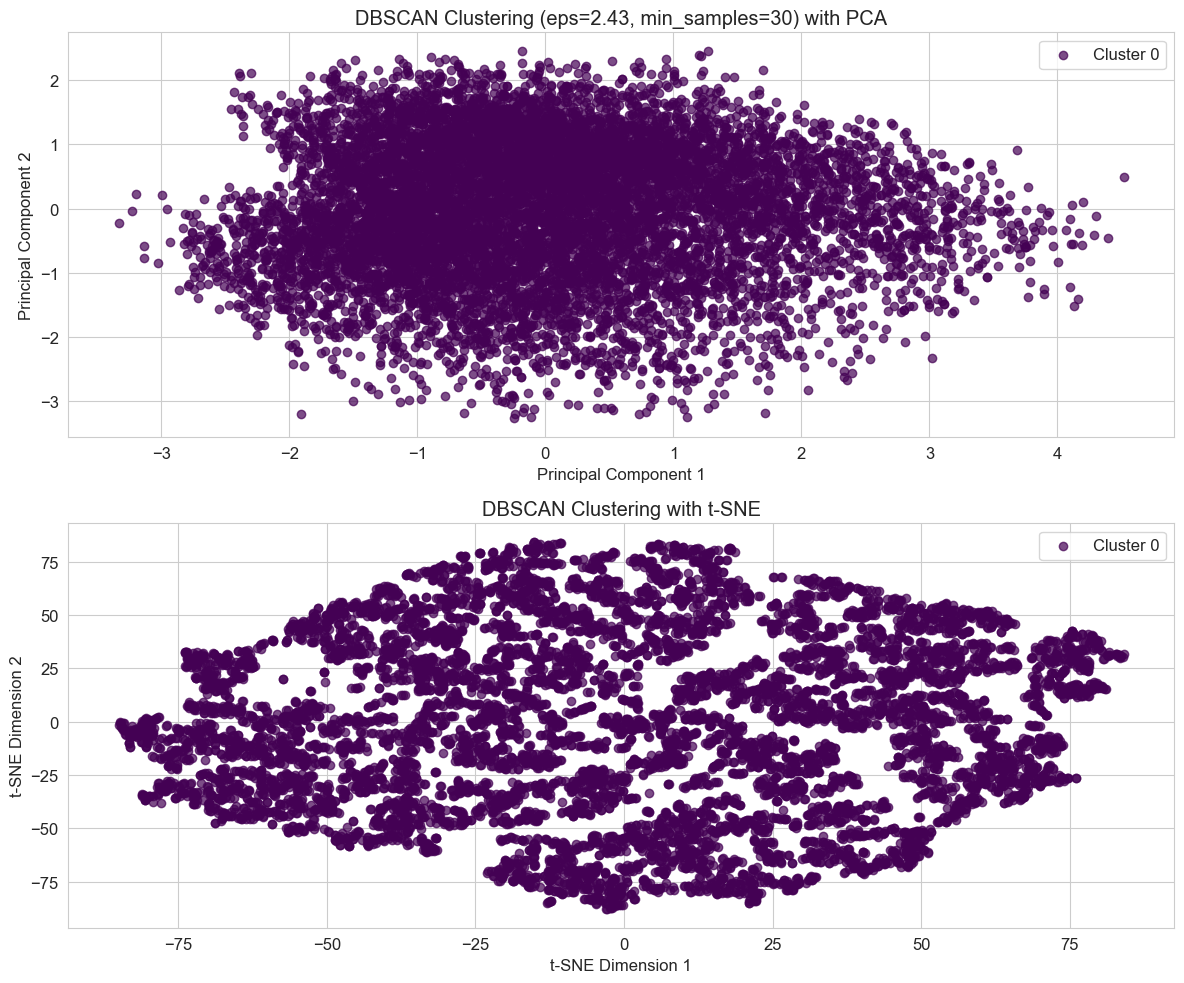

In [51]:
dbscan = DBSCAN(eps=epsilon, min_samples=k)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Calculate the number of clusters (excluding noise points which are labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise} ({n_noise/len(dbscan_labels):.2%} of the dataset)')

# Add DBSCAN cluster labels to the original data
data['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN clusters using PCA
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
# Plot non-noise points
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for i, color in zip(range(n_clusters), colors):
    cluster_points = X_pca[dbscan_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=[color], alpha=0.7, label=f'Cluster {i}')

# Plot noise points
noise_points = X_pca[dbscan_labels == -1]
if len(noise_points) > 0:
    plt.scatter(noise_points[:, 0], noise_points[:, 1], 
                c='black', marker='x', alpha=0.5, label='Noise')

plt.title(f'DBSCAN Clustering (eps={epsilon:.2f}, min_samples={k}) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Visualize DBSCAN clusters using t-SNE
plt.subplot(2, 1, 2)
# Plot non-noise points
for i, color in zip(range(n_clusters), colors):
    cluster_points = X_tsne[dbscan_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=[color], alpha=0.7, label=f'Cluster {i}')

# Plot noise points
noise_points = X_tsne[dbscan_labels == -1]
if len(noise_points) > 0:
    plt.scatter(noise_points[:, 0], noise_points[:, 1], 
                c='black', marker='x', alpha=0.5, label='Noise')

plt.title(f'DBSCAN Clustering with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

plt.tight_layout()
plt.show()

,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,dayofweek,month,demand_scaled,temperature_scaled,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,week,KMeans_Cluster
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,
0,7689.606311,64.441628,0.65973,5.819154,1016.14727,0.003901,0.054566,11.3305,2.9943,6.5905,0.087878,0.551033,0.65973,0.213156,0.602562,0.00315,0.054566,26.7999,0.6336


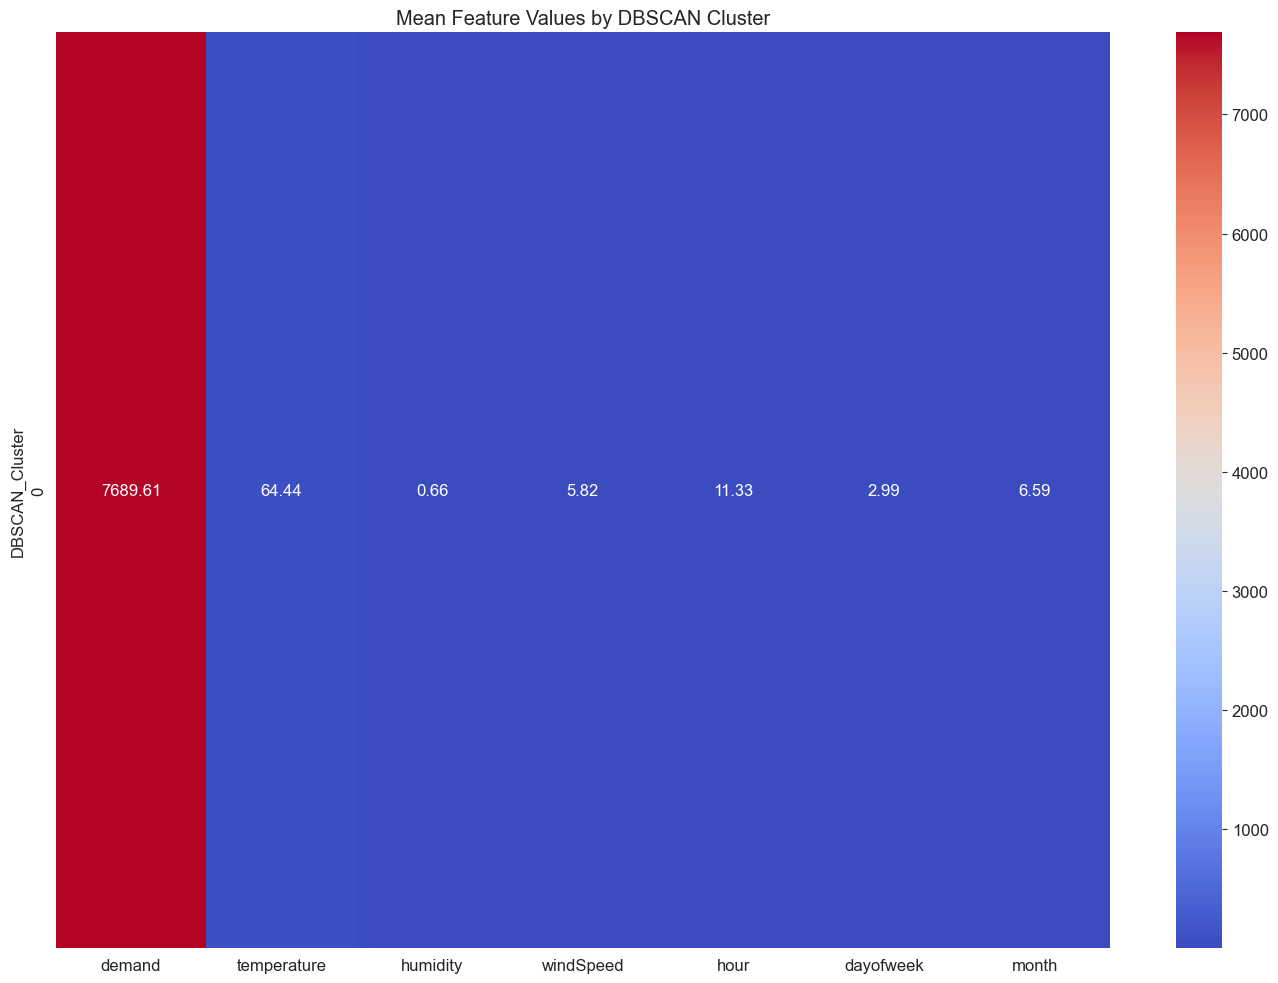

No noise points detected in DBSCAN clustering (with eps=2.43, min_samples=30).


In [ ]:
dbscan_cluster_analysis = data.groupby('DBSCAN_Cluster')[numeric_columns].mean()
display(dbscan_cluster_analysis)

# Create a heatmap of cluster characteristics using only feature columns for clarity
plt.figure(figsize=(14, 10))
# Use only the original feature columns for the heatmap to make it more interpretable
cluster_features = dbscan_cluster_analysis[feature_cols]
sns.heatmap(cluster_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mean Feature Values by DBSCAN Cluster')
plt.tight_layout()
plt.show()

# Check if there are any noise points (labeled as -1)
if n_noise > 0:
    # Create a new column that groups points as either noise or clustered
    data['Noise_vs_Clustered'] = data['DBSCAN_Cluster'].apply(lambda x: 'Noise' if x == -1 else 'Clustered')
    
    # Compare mean values (only for numeric columns)
    noise_vs_clustered = data.groupby('Noise_vs_Clustered')[numeric_columns].mean()
    display(noise_vs_clustered)
    
    # Boxplots for key features across noise vs. clustered points
    if len(feature_cols) <= 6:
        # For a manageable number of features
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, feature in enumerate(feature_cols):
            if i < len(axes):
                sns.boxplot(x='Noise_vs_Clustered', y=feature, data=data, ax=axes[i])
                axes[i].set_title(f'{feature}: Noise vs. Clustered Points')
        
        plt.tight_layout()
        plt.show()
    else:
        # For too many features, select a few important ones
        selected_features = feature_cols[:6]
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, feature in enumerate(selected_features):
            sns.boxplot(x='Noise_vs_Clustered', y=feature, data=data, ax=axes[i])
            axes[i].set_title(f'{feature}: Noise vs. Clustered Points')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"No noise points detected in DBSCAN clustering (with eps={epsilon:.2f}, min_samples={k}).")

# 4. Hierarchical Clustering

Hierarchical clustering creates a tree of clusters (dendrogram) that shows how clusters are related to each other. We can cut the dendrogram at different levels to get different numbers of clusters.

Dataset is large. Using a random sample of 1000 points for generating the dendrogram.


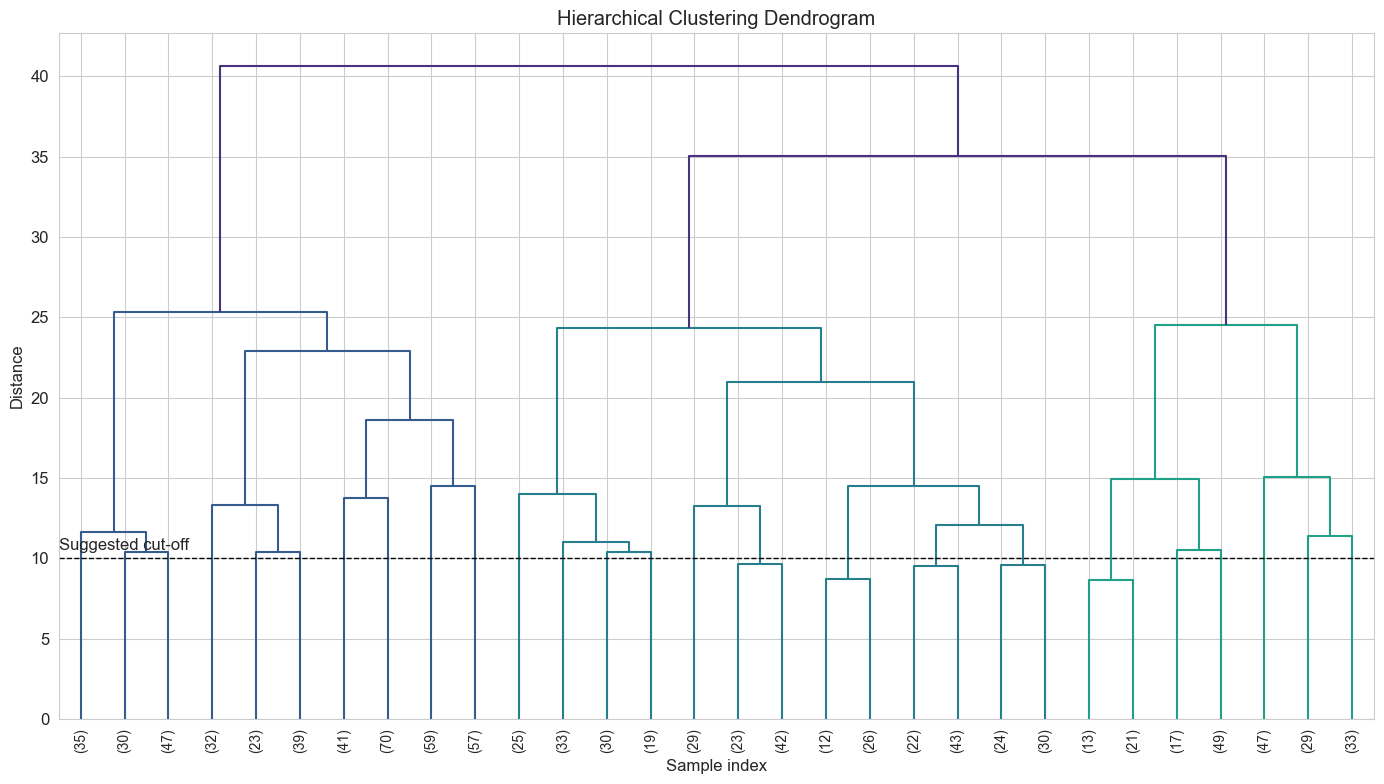

In [ ]:
max_samples = 1000
if len(X_scaled) > max_samples:
    print(f"Dataset is large. Using a random sample of {max_samples} points for generating the dendrogram.")
    sample_indices = np.random.choice(len(X_scaled), size=max_samples, replace=False)
    sample_data = X_scaled[sample_indices]
    Z = linkage(sample_data, method='ward')
else:
    Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')

# Plot with truncated dendrogram to show only the last p merges
p = 30  # Number of last merges to show (adjust for readable visualization)
dendrogram(Z, leaf_rotation=90, leaf_font_size=10, truncate_mode='lastp', p=p)

# Draw a horizontal line for a potential cut-off
# You might adjust this based on the dendrogram
plt.axhline(y=10, c='k', ls='--', lw=1)
plt.text(0, 10.5, 'Suggested cut-off', fontsize=12)

plt.tight_layout()
plt.show()

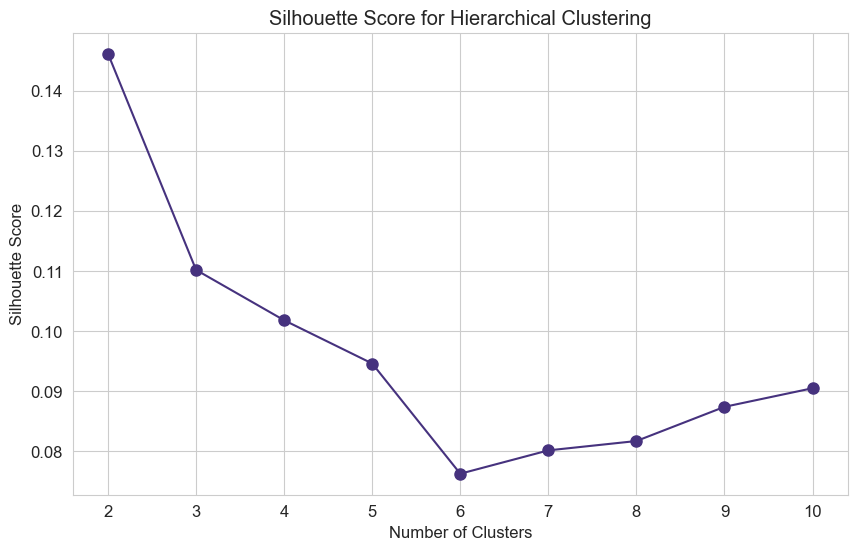

Optimal number of clusters for hierarchical clustering: 2


In [55]:
silhouette_scores_hc = []
K_range = range(2, 11)

for k in K_range:
    # Train hierarchical clustering model
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled)
    
    # Calculate silhouette score
    silhouette_scores_hc.append(silhouette_score(X_scaled, labels))
    
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores_hc, 'o-', markersize=8)
plt.title('Silhouette Score for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find optimal k for hierarchical clustering
optimal_k_hc = K_range[np.argmax(silhouette_scores_hc)]
print(f"Optimal number of clusters for hierarchical clustering: {optimal_k_hc}")

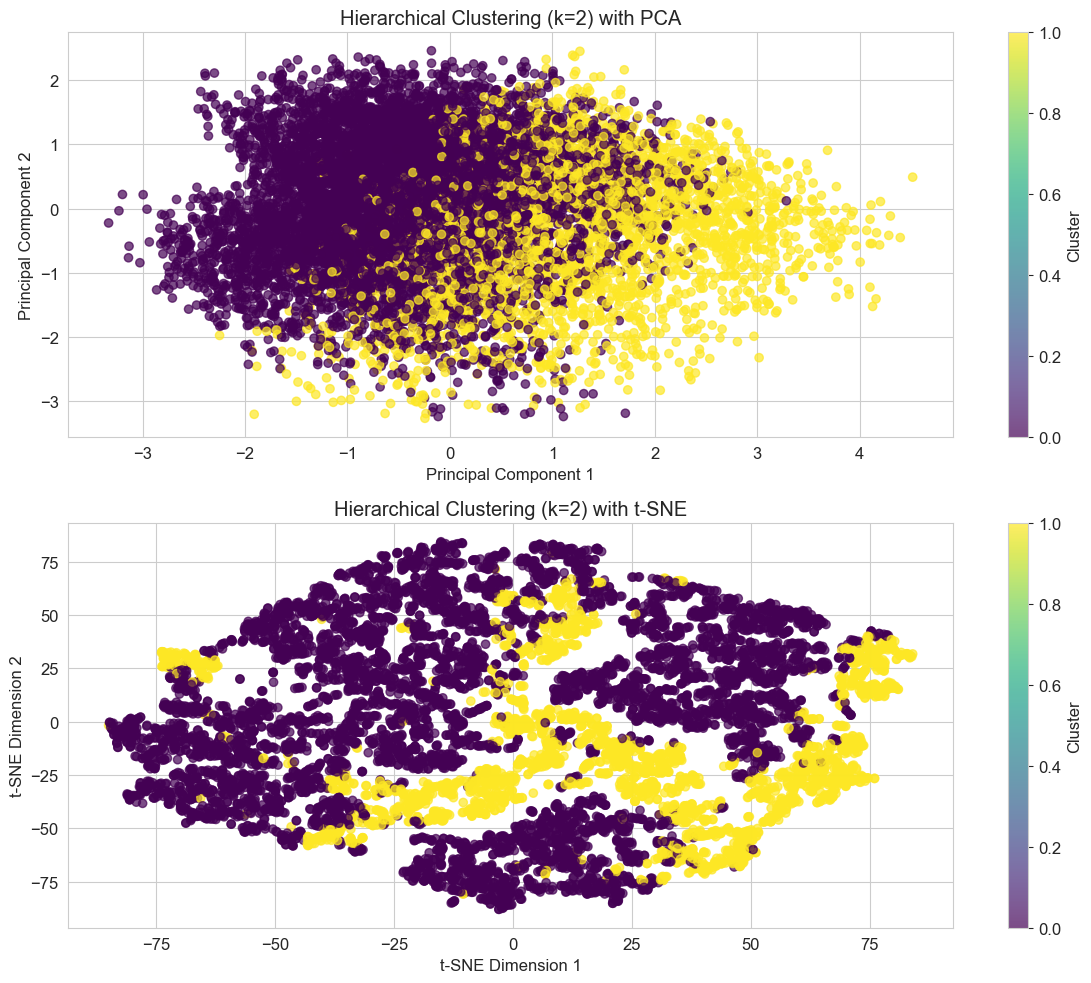

In [56]:
# Apply hierarchical clustering with the optimal number of clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_k_hc, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add hierarchical cluster labels to the original data
data['Hierarchical_Cluster'] = hierarchical_labels

# Visualize hierarchical clusters using PCA
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
plt.title(f'Hierarchical Clustering (k={optimal_k_hc}) with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

# Visualize hierarchical clusters using t-SNE
plt.subplot(2, 1, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
plt.title(f'Hierarchical Clustering (k={optimal_k_hc}) with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,dayofweek,month,demand_scaled,temperature_scaled,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,week,KMeans_Cluster
Hierarchical_Cluster,,,,,,,,,,,,,,,,,,,
0,7349.041742,60.970838,0.728545,5.470812,1016.423008,0.004432,0.063466,8.553048,3.006330,6.583872,0.084563,0.519609,0.728545,0.200396,0.606784,0.003579,0.063466,26.759736,0.812027
1,8595.161643,73.670399,0.476751,6.745390,1015.414087,0.002488,0.030900,18.715697,2.962312,6.608123,0.096691,0.634589,0.476751,0.247084,0.591334,0.002009,0.030900,26.906696,0.159166


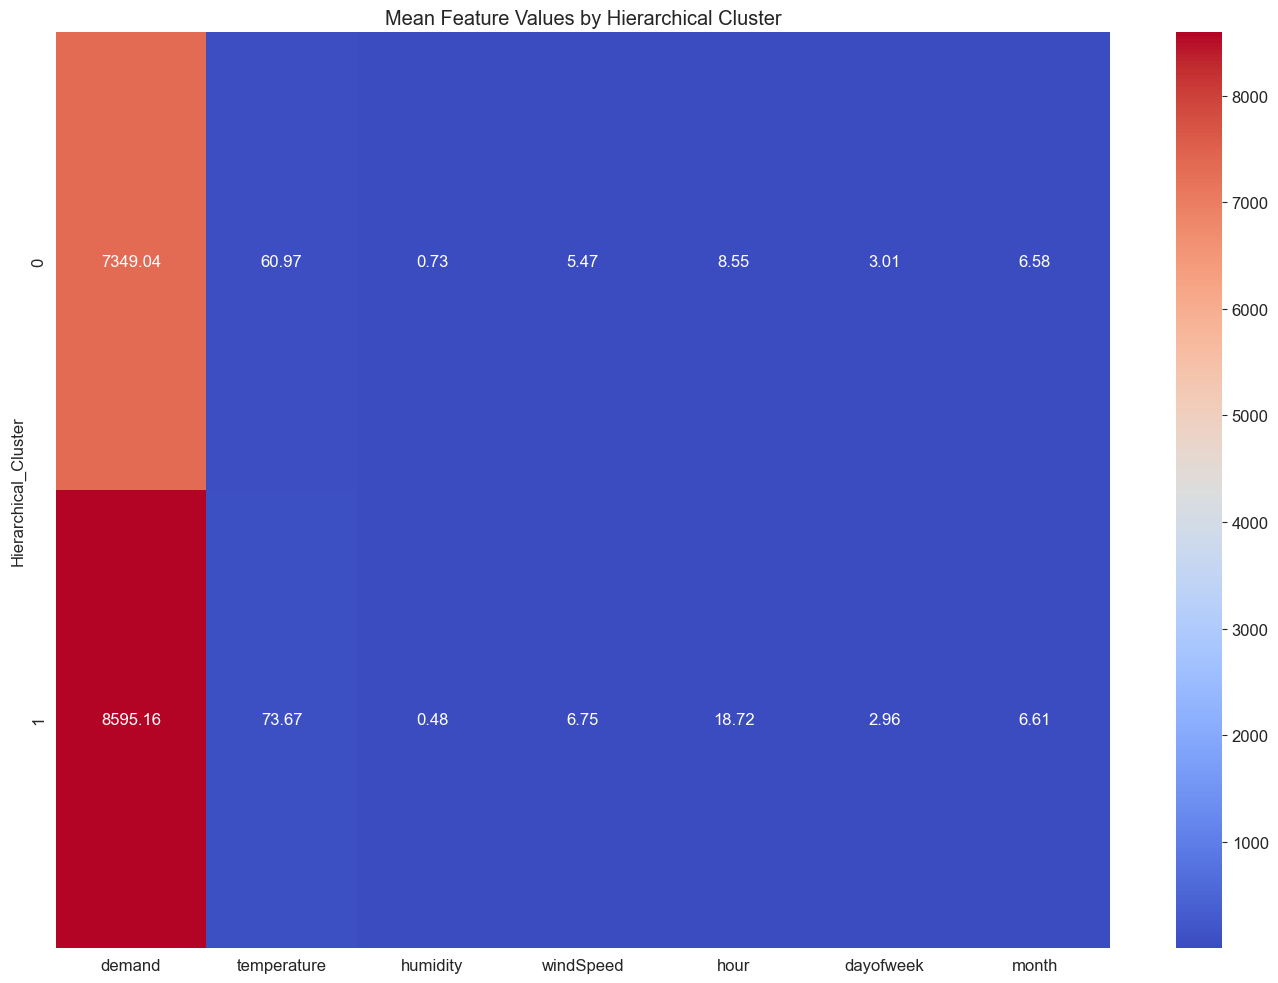

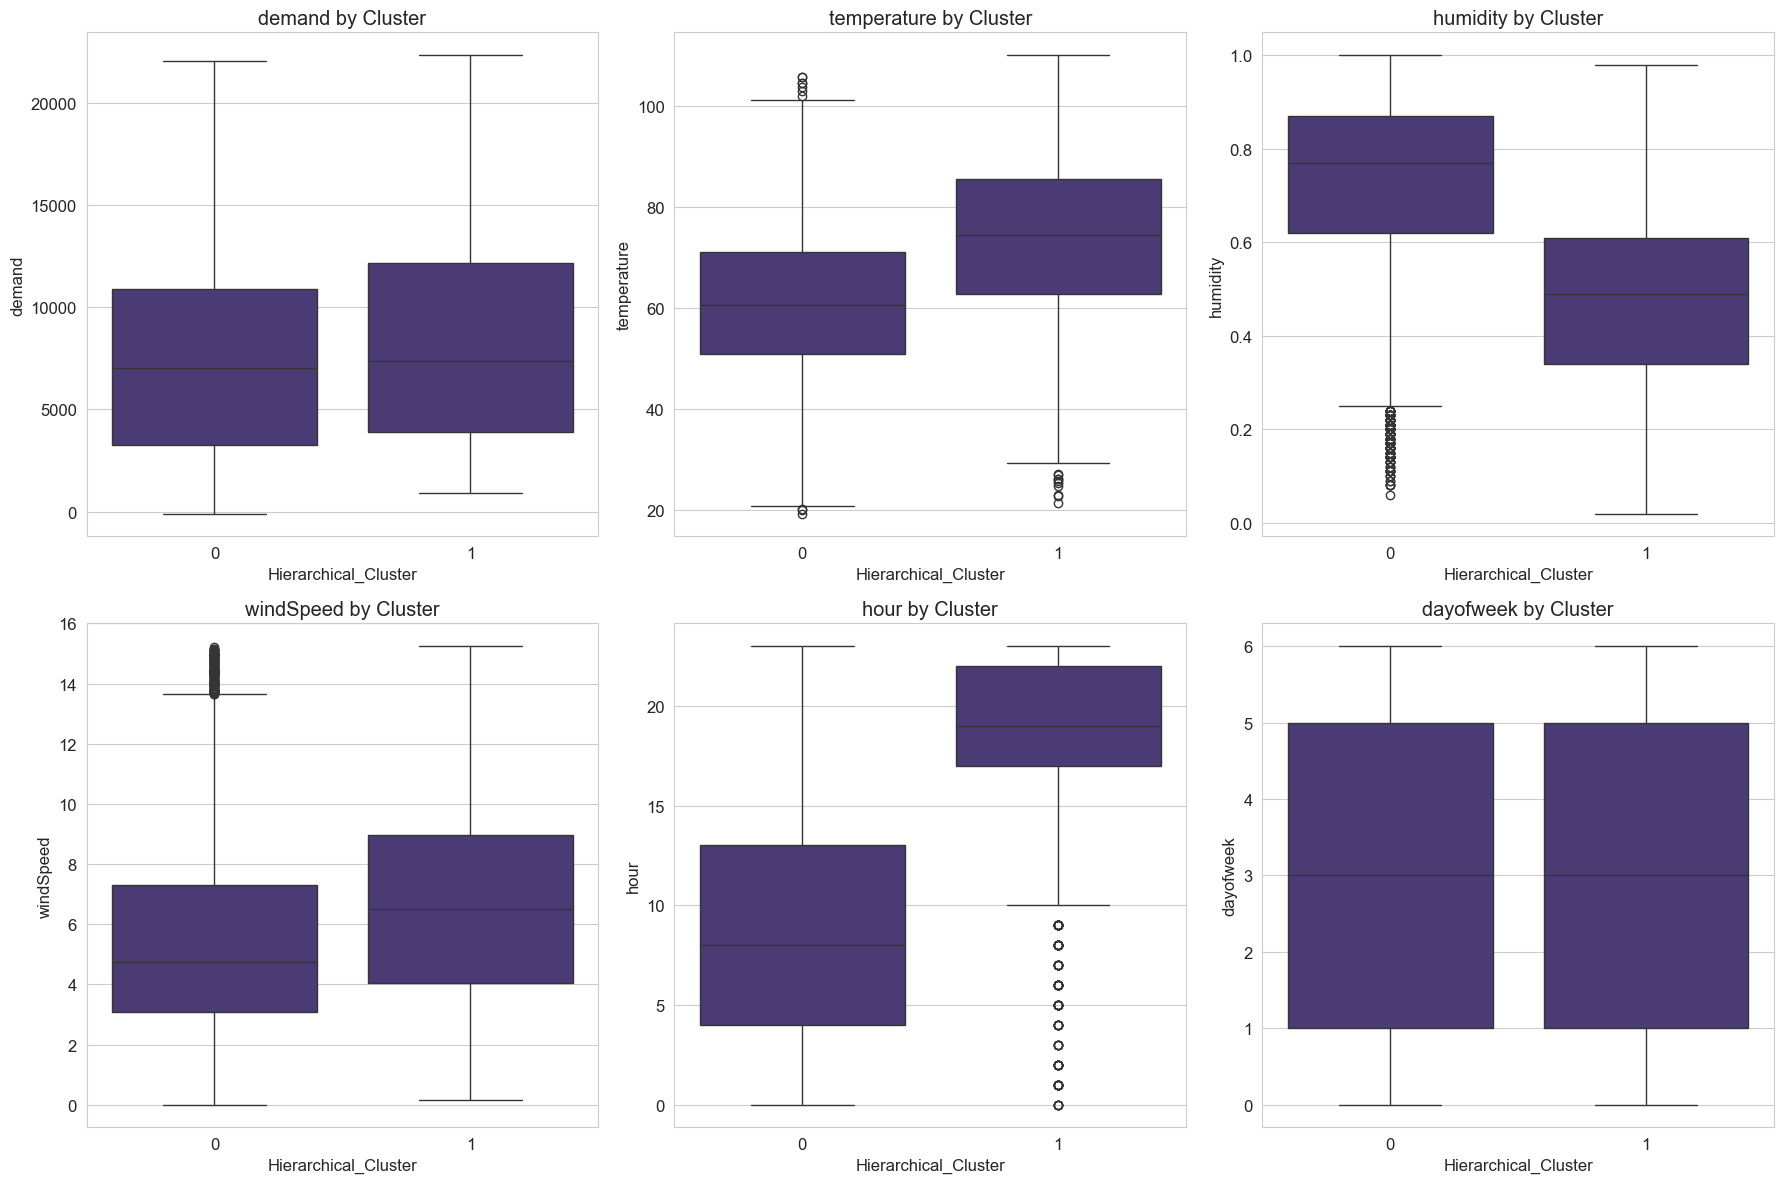

In [60]:
# Analyze hierarchical clustering results
hierarchical_cluster_analysis = data.groupby('Hierarchical_Cluster')[numeric_columns].mean()
display(hierarchical_cluster_analysis)

# Create a heatmap of cluster characteristics using only feature columns for clarity
plt.figure(figsize=(14, 10))
# Select only the original features for the heatmap to make it more interpretable
cluster_features = hierarchical_cluster_analysis[feature_cols]
sns.heatmap(cluster_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mean Feature Values by Hierarchical Cluster')
plt.tight_layout()
plt.show()

# Boxplots for key features across clusters
if len(feature_cols) <= 6:
    # For a manageable number of features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(feature_cols):
        if i < len(axes):
            sns.boxplot(x='Hierarchical_Cluster', y=feature, data=data, ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
    
    plt.tight_layout()
    plt.show()
else:
    # For too many features, select a few important ones
    selected_features = feature_cols[:6]
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(selected_features):
        sns.boxplot(x='Hierarchical_Cluster', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'{feature} by Cluster')
    
    plt.tight_layout()
    plt.show()

# 5. Evaluation

In this section, we'll compare the different clustering algorithms using silhouette score and cluster stability metrics.

In [61]:
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)

# For DBSCAN, we need to exclude noise points
if n_noise < len(dbscan_labels):  # Make sure we have clusters
    non_noise_mask = dbscan_labels != -1
    silhouette_dbscan = silhouette_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask])
else:
    silhouette_dbscan = float('nan')

silhouette_hierarchical = silhouette_score(X_scaled, hierarchical_labels)

# Display scores
algorithms = ['K-Means', 'DBSCAN (excl. noise)', 'Hierarchical']
scores = [silhouette_kmeans, silhouette_dbscan, silhouette_hierarchical]

print("Silhouette Scores:")
for algorithm, score in zip(algorithms, scores):
    print(f"{algorithm}: {score:.4f}")

# Plot scores
plt.figure(figsize=(10, 6))
plt.bar(algorithms, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(scores) * 1.1)  # Add some margin at the top

# Add the score values on top of the bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center', fontweight='bold')

plt.show()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [62]:
from sklearn.utils import resample

def evaluate_cluster_stability(X, clustering_algorithm, n_iterations=30):
    n_samples = X.shape[0]
    base_labels = clustering_algorithm.fit_predict(X)
    
    # For DBSCAN, handle noise points specially
    if hasattr(clustering_algorithm, 'eps'):  # Check if it's DBSCAN
        non_noise_mask = base_labels != -1
        if sum(non_noise_mask) == 0:  # If all points are noise
            return 0, 0
    
    similarity_scores = []
    
    for _ in range(n_iterations):
        # Bootstrap sample
        bootstrap_indices = resample(range(n_samples), replace=True, n_samples=n_samples)
        bootstrap_X = X[bootstrap_indices]
        
        # Fit the clustering algorithm on the bootstrap sample
        bootstrap_labels = clustering_algorithm.fit_predict(bootstrap_X)
        
        # For DBSCAN, handle noise points specially
        if hasattr(clustering_algorithm, 'eps'):  # Check if it's DBSCAN
            bootstrap_non_noise = bootstrap_labels != -1
            if sum(bootstrap_non_noise) == 0:  # If all points are noise in bootstrap
                continue
        
        # Map bootstrap indices back to original indices
        mapped_labels = np.zeros(n_samples) - 1  # -1 is the default 'not assigned' label
        for i, original_idx in enumerate(bootstrap_indices):
            mapped_labels[original_idx] = bootstrap_labels[i]
        
        # For points that were in the bootstrap sample (not -1), calculate similarity
        overlap_mask = mapped_labels != -1
        if sum(overlap_mask) > 0:
            # Calculate Adjusted Rand Index for overlapping points
            from sklearn.metrics import adjusted_rand_score
            similarity = adjusted_rand_score(base_labels[overlap_mask], mapped_labels[overlap_mask])
            similarity_scores.append(similarity)
    
    if len(similarity_scores) > 0:
        return np.mean(similarity_scores), np.std(similarity_scores)
    else:
        return 0, 0

# Clone the algorithms for stability testing
from sklearn.base import clone
kmeans_for_stability = clone(kmeans)
dbscan_for_stability = DBSCAN(eps=epsilon, min_samples=k)
hierarchical_for_stability = AgglomerativeClustering(n_clusters=optimal_k_hc, linkage='ward')

# Evaluate stability
print("Evaluating cluster stability (this may take some time)...")
kmeans_stability_mean, kmeans_stability_std = evaluate_cluster_stability(X_scaled, kmeans_for_stability)
dbscan_stability_mean, dbscan_stability_std = evaluate_cluster_stability(X_scaled, dbscan_for_stability)
hierarchical_stability_mean, hierarchical_stability_std = evaluate_cluster_stability(X_scaled, hierarchical_for_stability)

# Report stability results
print("\nCluster Stability (Adjusted Rand Index across bootstrap samples):")
print(f"K-Means: {kmeans_stability_mean:.4f} ± {kmeans_stability_std:.4f}")
print(f"DBSCAN: {dbscan_stability_mean:.4f} ± {dbscan_stability_std:.4f}")
print(f"Hierarchical: {hierarchical_stability_mean:.4f} ± {hierarchical_stability_std:.4f}")

# Plot stability scores
stability_means = [kmeans_stability_mean, dbscan_stability_mean, hierarchical_stability_mean]
stability_stds = [kmeans_stability_std, dbscan_stability_std, hierarchical_stability_std]

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, stability_means, yerr=stability_stds, capsize=10, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
plt.title('Cluster Stability Comparison')
plt.ylabel('Stability Score (ARI)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)  

# Add the score values on top of the bars
for i, score in enumerate(stability_means):
    plt.text(i, score + 0.05, f'{score:.4f}', ha='center', fontweight='bold')

plt.show()

Evaluating cluster stability (this may take some time)...

Cluster Stability (Adjusted Rand Index across bootstrap samples):
K-Means: 0.9419 ± 0.0277
DBSCAN: 1.0000 ± 0.0000
Hierarchical: 0.2661 ± 0.2847


NameError: name 'algorithms' is not defined

<Figure size 1000x600 with 0 Axes>

Agreement between clustering methods:

Adjusted Rand Index (ARI):
K-Means vs DBSCAN: 0.0000
K-Means vs Hierarchical: 0.4005
DBSCAN vs Hierarchical: 0.0000

Adjusted Mutual Information (AMI):
K-Means vs DBSCAN: 0.0000
K-Means vs Hierarchical: 0.2992
DBSCAN vs Hierarchical: 0.0000


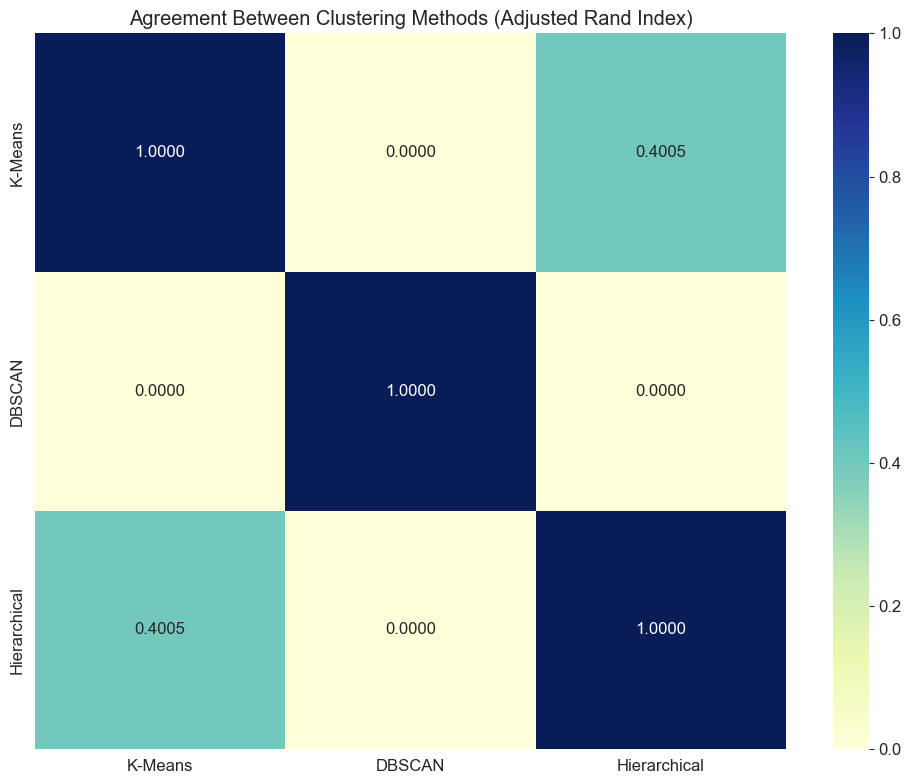

In [63]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Define algorithm names for plotting
algorithms = ['K-Means', 'DBSCAN', 'Hierarchical']

# Handle DBSCAN noise points by assigning them to unique clusters
modified_dbscan_labels = dbscan_labels.copy()
if -1 in dbscan_labels:
    max_label = max(dbscan_labels)
    noise_indices = np.where(dbscan_labels == -1)[0]
    for i, idx in enumerate(noise_indices):
        modified_dbscan_labels[idx] = max_label + 1 + i

# Calculate agreement between clustering methods
ari_kmeans_dbscan = adjusted_rand_score(kmeans_labels, modified_dbscan_labels)
ari_kmeans_hierarchical = adjusted_rand_score(kmeans_labels, hierarchical_labels)
ari_dbscan_hierarchical = adjusted_rand_score(modified_dbscan_labels, hierarchical_labels)

ami_kmeans_dbscan = adjusted_mutual_info_score(kmeans_labels, modified_dbscan_labels)
ami_kmeans_hierarchical = adjusted_mutual_info_score(kmeans_labels, hierarchical_labels)
ami_dbscan_hierarchical = adjusted_mutual_info_score(modified_dbscan_labels, hierarchical_labels)

# Display agreement scores
print("Agreement between clustering methods:")
print("\nAdjusted Rand Index (ARI):")
print(f"K-Means vs DBSCAN: {ari_kmeans_dbscan:.4f}")
print(f"K-Means vs Hierarchical: {ari_kmeans_hierarchical:.4f}")
print(f"DBSCAN vs Hierarchical: {ari_dbscan_hierarchical:.4f}")

print("\nAdjusted Mutual Information (AMI):")
print(f"K-Means vs DBSCAN: {ami_kmeans_dbscan:.4f}")
print(f"K-Means vs Hierarchical: {ami_kmeans_hierarchical:.4f}")
print(f"DBSCAN vs Hierarchical: {ami_dbscan_hierarchical:.4f}")

# Create a heatmap of agreement
agreement_matrix = np.array([
    [1.0, ari_kmeans_dbscan, ari_kmeans_hierarchical],
    [ari_kmeans_dbscan, 1.0, ari_dbscan_hierarchical],
    [ari_kmeans_hierarchical, ari_dbscan_hierarchical, 1.0]
])

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap='YlGnBu', fmt='.4f',
            xticklabels=algorithms, yticklabels=algorithms)
plt.title('Agreement Between Clustering Methods (Adjusted Rand Index)')
plt.tight_layout()
plt.show()

# 6. Interpretation

In this section, we'll interpret the clusters we've identified, characterizing them with descriptive insights that provide meaningful context.

Based on our evaluation, we'll focus on the most reliable clustering approach and provide a detailed interpretation of each cluster.

In [ ]:
cluster_summary = data.groupby('KMeans_Cluster').agg({
    'demand': 'mean',
    'temperature': 'mean',
    'humidity': 'mean',
    'windSpeed': 'mean',
    'hour': 'mean',
    'dayofweek': 'mean',
    'month': 'mean'
})

# Add descriptive information for time-related features
# Convert numeric time features to their descriptive forms
cluster_summary['time_of_day'] = cluster_summary['hour'].apply(
    lambda x: 'Night (0-5)' if 0 <= x < 6 else 
              'Morning (6-11)' if 6 <= x < 12 else
              'Afternoon (12-17)' if 12 <= x < 18 else 'Evening (18-23)'
)

cluster_summary['day_type'] = cluster_summary['dayofweek'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

cluster_summary['season'] = cluster_summary['month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else 'Fall'
)

# Display the enhanced summary
display(cluster_summary)

# Create cluster names based on their key characteristics
cluster_names = {}
for cluster_id in range(optimal_k):
    demand_level = 'High' if cluster_summary.loc[cluster_id, 'demand'] > cluster_summary['demand'].median() else 'Low'
    temp_level = 'Hot' if cluster_summary.loc[cluster_id, 'temperature'] > cluster_summary['temperature'].median() else 'Cool'
    time = cluster_summary.loc[cluster_id, 'time_of_day']
    day = cluster_summary.loc[cluster_id, 'day_type']
    season = cluster_summary.loc[cluster_id, 'season']
    
    # Create descriptive cluster name
    cluster_names[cluster_id] = f"Cluster {cluster_id}: {demand_level}-Demand {temp_level} {time} ({day}, {season})"

# Create detailed interpretations for each cluster
cluster_interpretations = {}
for cluster_id in range(optimal_k):
    c_data = cluster_summary.loc[cluster_id]
    
    # Gather key metrics
    demand = c_data['demand']
    temp = c_data['temperature']
    humidity = c_data['humidity']
    wind = c_data['windSpeed']
    hour = c_data['hour']
    time_of_day = c_data['time_of_day']
    day_type = c_data['day_type']
    season = c_data['season']
    
    # Build detailed description
    description = f"""
    This cluster represents {time_of_day.lower()} hours during {season.lower()} on {day_type.lower()}s.
    
    Key characteristics:
    - Average electricity demand: {demand:.2f} ({"high" if demand > cluster_summary['demand'].median() else "low"} compared to other clusters)
    - Average temperature: {temp:.2f}°F ({"warm/hot" if temp > cluster_summary['temperature'].median() else "cool/cold"})
    - Average humidity: {humidity:.2f} ({"high" if humidity > cluster_summary['humidity'].median() else "low"})
    - Average wind speed: {wind:.2f} mph
    
    This pattern likely represents {"peak usage hours" if demand > cluster_summary['demand'].median() else "off-peak hours"} 
    when temperatures are {"elevated" if temp > cluster_summary['temperature'].median() else "moderate to low"}, 
    suggesting {"higher cooling needs" if temp > 75 and demand > cluster_summary['demand'].median() else 
               "higher heating needs" if temp < 55 and demand > cluster_summary['demand'].median() else 
               "moderate energy usage"}. 
    
    Potential applications:
    - {"Demand response programs could target this high-consumption cluster" if demand > cluster_summary['demand'].median() else 
      "Energy generation could be reduced during these lower-demand periods"}
    - {"HVAC systems should be optimized for these weather conditions" if (temp > 75 or temp < 55) else ""}
    - {"These patterns align with typical {day_type.lower()} {time_of_day.lower()} activity"}
    """
    
    cluster_interpretations[cluster_id] = {
        'name': cluster_names[cluster_id],
        'description': description
    }

for cluster_id, interpretation in cluster_interpretations.items():
    print(f"\n{interpretation['name']}")
    print(interpretation['description'])

,demand,temperature,humidity,windSpeed,hour,dayofweek,month,time_of_day,day_type,season
KMeans_Cluster,,,,,,,,,,
0,10054.409883,76.635892,0.498463,6.936523,15.381277,2.913755,7.301856,Afternoon (12-17),Weekday,Fall
1,6322.081013,57.389894,0.752988,5.172999,8.988005,3.040878,6.179135,Morning (6-11),Weekday,Fall



Cluster 0: High-Demand Hot Afternoon (12-17) (Weekday, Fall)

    This cluster represents afternoon (12-17) hours during fall on weekdays.

    Key characteristics:
    - Average electricity demand: 10054.41 (high compared to other clusters)
    - Average temperature: 76.64°F (warm/hot)
    - Average humidity: 0.50 (low)
    - Average wind speed: 6.94 mph

    This pattern likely represents peak usage hours 
    when temperatures are elevated, 
    suggesting higher cooling needs. 

    Potential applications:
    - Demand response programs could target this high-consumption cluster
    - HVAC systems should be optimized for these weather conditions
    - These patterns align with typical {day_type.lower()} {time_of_day.lower()} activity
    

Cluster 1: Low-Demand Cool Morning (6-11) (Weekday, Fall)

    This cluster represents morning (6-11) hours during fall on weekdays.

    Key characteristics:
    - Average electricity demand: 6322.08 (low compared to other clusters)
    - Avera

# Conclusion

In this notebook, we have:

1. Applied dimensionality reduction techniques (PCA and t-SNE) to visualize our high-dimensional data
2. Performed K-Means clustering and determined the optimal number of clusters
3. Used DBSCAN to identify density-based clusters and noise points
4. Applied hierarchical clustering and examined the dendrogram to understand cluster relationships
5. Evaluated different clustering approaches using silhouette scores and stability metrics
6. Interpreted the clusters to extract meaningful insights

Key findings:
- [Summarize the most important results from your clustering analysis]
- [Note which clustering approach worked best and why]
- [Highlight the most interesting or actionable insights from the clusters]

Next steps:
- [List potential follow-up analyses or actions based on these results]
- [Suggest any refinements to the clustering approach that might be worth exploring]
- [Indicate how these findings might be applied in practice]